In [1]:
from mne.datasets import multimodal
import mne
mne.set_log_level(verbose='CRITICAL')
import os
import sys
sys.path.insert(1, os.path.realpath(os.path.pardir))
from deepmeg.training.callbacks import Callback, EarlyStopping, L2Reg
from deepmeg.training.trainers import Trainer
from deepmeg.data.datasets import read_epochs_dataset, EpochsDataset
from deepmeg.preprocessing.transforms import zscore
from deepmeg.models import BaseModel
import torch
from torch.utils.data import DataLoader
import torch.nn as nn
from collections import defaultdict
from deepmeg.data.utils import make_train_and_val_loaders
from torch.utils.data import DataLoader, Dataset
import torchmetrics
from deepmeg.training.callbacks import PrintingCallback
import matplotlib.pyplot as plt
import numpy as np
from deepmeg.utils.convtools import compute_output_shape, conviter
import scipy as sp

In [2]:

def plot_metrics(metrics: dict[str, np.ndarray]):
    plot_dict = defaultdict(dict)

    for metric, values in metrics.items():
        metric_data = metric.split('_')
        metric_name = '_'.join(metric_data[:-1])
        metric_kind = metric_data[-1]
        plot_dict[metric_name][metric_kind] = values

    for metric_name, kind_dict in plot_dict.items():
        legend = list()
        for metric_kind, kind in kind_dict.items():
            plt.plot(kind)
            legend.append(metric_kind)
        plt.title(metric_name)
        plt.legend(legend)
        plt.show()


def gaussian_random_walk(n: int, stepsize: float = 1.0) -> np.ndarray:
    """
    Generates a Gaussian random walk for a given number of points using numpy.

    Args:
        n: the number of points in the random walk
        stepsize: the standard deviation of the Gaussian distribution used to generate the random steps (default is 1.0)

    Returns:
        A numpy array of shape (n, 2) representing the x and y coordinates of the random walk.
    """
    # Generate random steps using a Gaussian distribution
    steps = np.random.normal(loc=0, scale=stepsize, size=(n, 2))

    # Compute the coordinates of the random walk by cumulatively summing the steps
    walk = np.cumsum(steps, axis=0)

    return walk.T[0]


def moving_average(data: np.ndarray, kernel_size: int = 20) -> np.ndarray:
    """
    Compute the moving average of a given data array.

    Parameters
    ----------
    data : np.ndarray
        The data array.
    kernel_size : int
        The size of the kernel.

    Returns
    -------
    np.ndarray
        The moving average of the data array.
    """
    kernel = np.ones(kernel_size) / kernel_size
    return np.convolve(data, kernel, mode='same')

def interpolate_sequence(original_sequence: np.ndarray, new_length: int) -> np.ndarray:
    """
    Interpolate a sequence of length 'n' into a sequence of length 'm' (m > n)

    Args:
        original_sequence: A numpy array of shape (n, ) representing the original sequence
        new_length: An integer, the desired length of the interpolated sequence

    Returns:
        A numpy array of shape (m, ) representing the interpolated sequence
    """
    x = np.arange(original_sequence.shape[0])
    f = original_sequence
    x_new = np.linspace(0, x.max(), new_length)
    f_new = np.interp(x_new, x, f)
    return f_new

# very simple function to plot history of the model training

def plot_metrics(metrics: dict[str, np.ndarray]):
    plot_dict = defaultdict(dict)

    for metric, values in metrics.items():
        metric_data = metric.split('_')
        metric_name = '_'.join(metric_data[:-1])
        metric_kind = metric_data[-1]
        plot_dict[metric_name][metric_kind] = values

    for metric_name, kind_dict in plot_dict.items():
        legend = list()
        for metric_kind, kind in kind_dict.items():
            plt.plot(kind)
            legend.append(metric_kind)
        plt.title(metric_name)
        plt.legend(legend)
        plt.show()

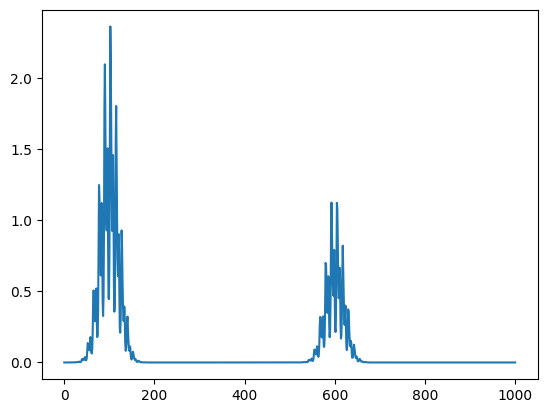

In [3]:
t = np.linspace(0, 1000, 1000)

s = 0.5 * (
        np.exp(
            np.sin(t/2)
        ) + np.exp(
            np.sin(t)
        )
    ) * np.exp(
        -(t - 100)**2 / (2 * 20**2)
    ) + 0.25*(
        np.exp(
            np.sin(t/2)
        ) + np.exp(
            np.sin(t)
        )
    ) * np.exp(
        -(t - 600)**2 / (2 * 20**2)
    )

plt.plot(t, s)

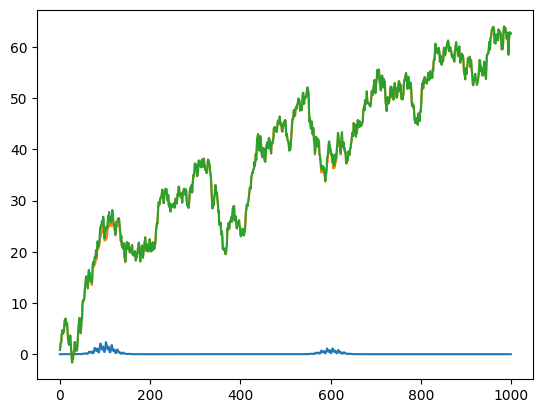

In [4]:
import scipy as sp

original_sig = s#gaussian_random_walk(100)
additional_sig = gaussian_random_walk(1000)
# additional_sig = np.random.uniform(-5, 5, 1000)
# additional_sig = np.random.normal(0, 2, 1000)

plt.plot(original_sig)
plt.plot(additional_sig)
plt.plot(original_sig + additional_sig)

In [5]:
n_epochs = 1000
n_channels = 10

poor_data = np.array([ [ sp.signal.detrend(gaussian_random_walk(1000)) for __ in range(n_channels)] for _ in range(n_epochs)])

# distances = np.random.random(n_channels)
distances = np.random.normal(0.5, .2, n_channels)
ratio = 2*np.random.randint(0, 2, n_channels) - 1

In [6]:
# poor_data -= poor_data[200: 500].mean(0)
poor_data -= poor_data.mean(0)

# rich_data = np.array([ [ channel + distance*original_sig for channel, distance in zip(epoch, distances) ] for epoch in poor_data])
rich_data = np.array([ [ channel + r*distance*original_sig for r, channel, distance in zip(ratio, epoch, distances) ] for epoch in poor_data])

In [7]:
poor_data.shape

(1000, 10, 1000)

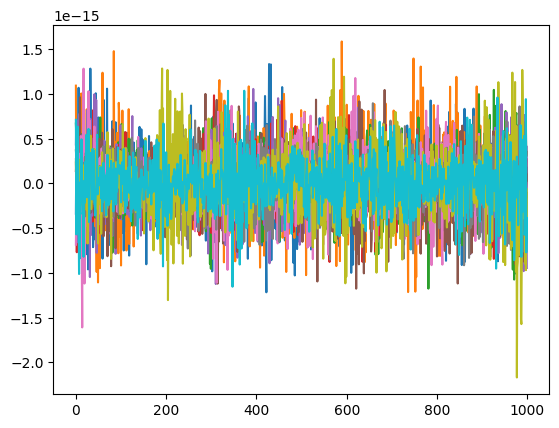

In [8]:
fig = plt.plot(poor_data.mean(0).T)

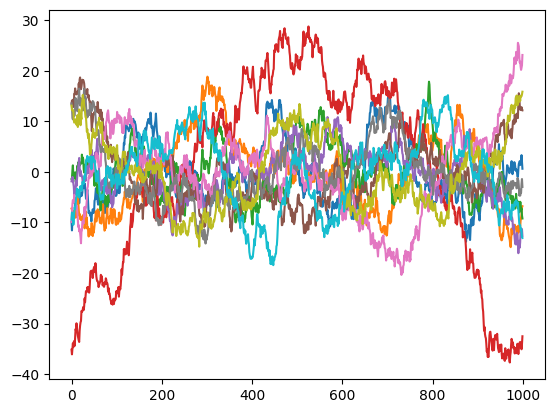

In [9]:
i = int(np.random.randint(len(rich_data)))

fig = plt.plot(rich_data[i].T)
# plt.legend(np.round(distances, 2), ncol=2, loc='upper right')

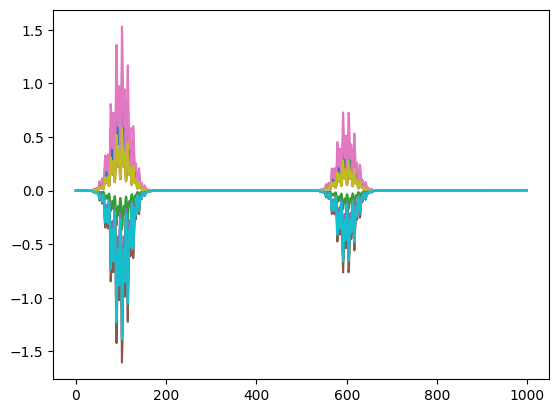

In [10]:
fig = plt.plot(rich_data.mean(0).T)
# plt.legend(np.round(distances, 2), ncol=2, loc='upper right')

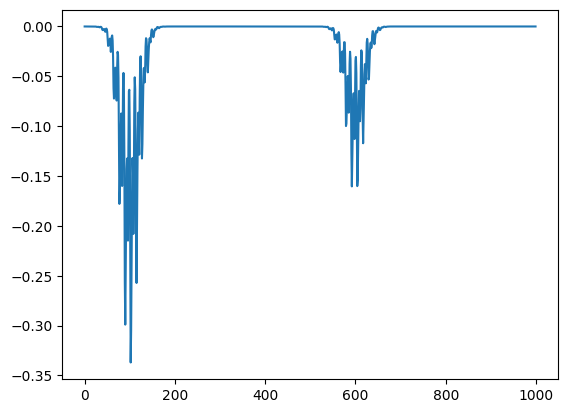

In [11]:
fig = plt.plot(rich_data.mean((0, 1)).T)

In [12]:
X = rich_data
Y = np.array([original_sig for _ in range(len(X))])

In [13]:
from deepmeg.preprocessing.transforms import zscore

dataset = EpochsDataset((X, Y), transform=zscore, target_transform=zscore, savepath='../datasets/simulated_sources')
dataset.save('../data/simulated_sources.pt')

In [14]:
dataset = EpochsDataset.load('../data/simulated_sources.pt')

In [15]:
train, test = torch.utils.data.random_split(dataset, [.7, .3])

In [16]:
import torch.nn as nn
import torch.nn.init as init
import math
import torch


class TS(nn.Module):
    def __init__(self, n_channels, n_times):
        super().__init__()
        self.n_channels = n_channels
        self.n_times = n_times
        self.i = nn.Parameter(torch.empty(self.n_times, self.n_channels))
        # self.s = nn.Parameter(torch.empty(1, self.n_channels))
        self.b = nn.Parameter(torch.empty(1, self.n_times))
        self.reset_parameters()
        self.x_prev = 0

    def reset_parameters(self) -> None:
        init.uniform_(self.i, -0.01, 0.01)
        init.uniform_(self.b, -0.01, 0.01)
        # init.uniform_(self.s, -0.01, 0.01)

    def forward(self, x):
        # out = torch.zeros(x.shape[0], self.n_times)
        out = torch.zeros_like(x)
        for i in range(self.n_times):
            timepoint = x[:, :, i]
            # print(timepoint.shape)
            # sp_filter = self.i[i]@self.s
            # out[:, i] = self.i[i]@timepoint.T
            out[:, :, i] = timepoint*self.i[i]

        return out + self.b


X = torch.rand(70, 10, 100)
TS(10, 100)(X).shape

torch.Size([70, 10, 100])

In [17]:
from deepmeg.training.trainers import Trainer


class CustomTrainer(Trainer):

    @torch.no_grad()
    def evaluate_batch(self, val_iterator, eval_on_n_batches: int) -> dict[str, float]:
        predictions = []
        targets = []

        losses = []

        for real_batch_number in range(eval_on_n_batches):

            try:
                xs, ys_true = next(val_iterator)

                xs = xs.to(self.device)
                ys_true = ys_true.to(self.device)

                if self.callbacks:
                    for callback in self.callbacks:
                        callback.on_batch_begin(xs, ys_true)
                        callback.on_eval_batch_begin(xs, ys_true)
                if self._interrupt:
                    break
            except StopIteration:
                if real_batch_number == 0:
                    return None
                else:
                    break

            ys_pred = self.model.eval()(xs)
            loss = self.criterion(xs, ys_pred)

            if self.callbacks:
                for callback in self.callbacks:
                    new_loss = callback.on_loss_computed(xs, ys_true, ys_pred, loss)

                    if new_loss is not None:
                        loss = new_loss

            losses.append(loss.item())

            predictions.append(ys_pred.cpu())
            targets.append(ys_true.cpu())

        predictions = torch.cat(predictions, dim=0)
        targets = torch.cat(targets, dim=0)

        metrics = {'loss': np.mean(losses)}

        for metric_name, metric_fn in self.metric_functions:
            metrics[metric_name] = metric_fn(predictions, targets).item()

        if self.callbacks:
            for callback in self.callbacks:
                callback.on_batch_end(targets, predictions, metrics)
                callback.on_eval_batch_end(targets, predictions, metrics)

        return metrics

    def fit_batch(self, train_iterator, update_every_n_batches: int) -> dict[str, float]:

        self.optimizer.zero_grad()

        predictions = []
        targets = []

        losses = []

        for real_batch_number in range(update_every_n_batches):

            try:
                xs, ys_true = next(train_iterator)

                xs = xs.to(self.device)
                ys_true = ys_true.to(self.device)

                if self.callbacks:
                    for callback in self.callbacks:
                        callback.on_batch_begin(xs, ys_true)
                        callback.on_train_batch_begin(xs, ys_true)

                if self._interrupt:
                    raise StopIteration
            except StopIteration:
                if real_batch_number == 0:
                    return None
                else:
                    break

            ys_pred = self.model.train()(xs)
            loss = self.criterion(xs, ys_pred)

            if self.callbacks:
                for callback in self.callbacks:
                    new_loss = callback.on_loss_computed(xs, ys_true, ys_pred, loss)

                    if new_loss is not None:
                        loss = new_loss

            (loss / update_every_n_batches).backward()
            losses.append(loss.item())

            predictions.append(ys_pred.cpu())
            targets.append(ys_true.cpu())

        self.optimizer.step()

        predictions = torch.cat(predictions, dim=0)
        targets = torch.cat(targets, dim=0)

        metrics = {'loss': np.mean(losses)}

        for metric_name, metric_fn in self.metric_functions:
            metrics[metric_name] = metric_fn(predictions, targets).item()

        if self.callbacks:
            for callback in self.callbacks:
                callback.on_batch_end(targets, predictions, metrics)
                callback.on_train_batch_end(targets, predictions, metrics)

        return metrics

In [18]:
class Loss(object):
    def __init__(self):
        self._prev = None
        self.cr = nn.L1Loss()

    def __call__(self, data, pred):
        if self._prev is None:
            self._prev = torch.zeros_like(pred)
        # print(pred.shape, self._prev.shape)
        # out = torch.abs((pred - self._prev[:pred.shape[0]]).mean(0).sum())
        out = torch.abs((pred.mean(0) - self._prev[:pred.shape[0]].mean(0)).mean(0).sum())
        self._prev = pred.detach().clone()
        minsize = min(pred.shape[0], self._prev.shape[0])
        # return torch.abs((pred - self._prev[:pred.shape[0]]).sum())
        # losses = list()
        # for i in range(pred.shape[1]):
        #     losses.append(self.cr(pred[:, i, :], self._prev[:pred.shape[0]]))
        # return self.cr(pred, self._prev[:pred.shape[0]])
        return out


class TSUnmixer(BaseModel):
    def __init__(self, n_channels, n_times):
        super().__init__()
        self.unmixing_layer = TS(n_channels, n_times)

    def forward(self, x):
        return self.unmixing_layer(x)

In [19]:
x, y = next(iter(DataLoader(train, 2)))

In [20]:
x.shape

torch.Size([2, 10, 1000])

In [21]:
model = TSUnmixer(
    n_channels=x.shape[1],
    n_times=x.shape[-1]
)

# if you want to define optimizer, do not forget to specify model parameters (e.g., torch.optim.Adam(model.parameters()))
optimizer = torch.optim.Adam

# loss = torch.nn.BCEWithLogitsLoss()
# loss = torch.nn.L1Loss()
loss = Loss()
# metric = torchmetrics.functional.classification.binary_accuracy

# in model compilation two callbacks are used: PrintingCallback is used to print training history and EarlyStopping is used to prevent overfitting
model.compile(
    optimizer,
    loss,
    # metric,
    callbacks=[
        PrintingCallback(),
        EarlyStopping(monitor='loss_val', patience=15, restore_best_weights=True),
        # L2Reg(
        #     [
        #         'unmixing_layer.weight'
        #     ], lambdas=.01
        # )
    ],
    trainer=CustomTrainer
)

In [176]:
sys.stdout = sys.stdout.file

Epoch 0:  loss_train:  0.4002   |    loss_val:  0.1172
Epoch 1:  loss_train:  0.2157   |    loss_val:  0.0897
Epoch 2:  loss_train:  0.1878   |    loss_val:  0.1052
Epoch 3:  loss_train:  0.1662   |    loss_val:  0.0084
Epoch 4:  loss_train:  0.0699   |    loss_val:  0.0511
Epoch 5:  loss_train:  0.0653   |    loss_val:  0.0200
Epoch 6:  loss_train:  0.0384   |    loss_val:  0.0391
Epoch 7:  loss_train:  0.0596   |    loss_val:  0.0297
Epoch 8:  loss_train:  0.0358   |    loss_val:  0.0338
Epoch 9:  loss_train:  0.0569   |    loss_val:  0.0345
Epoch 10: loss_train:  0.0346   |    loss_val:  0.0311
Epoch 11: loss_train:  0.0556   |    loss_val:  0.0370
Epoch 12: loss_train:  0.0341   |    loss_val:  0.0298
Epoch 13: loss_train:  0.0549   |    loss_val:  0.0382
Epoch 14: loss_train:  0.0337   |    loss_val:  0.0291
Epoch 15: loss_train:  0.0545   |    loss_val:  0.0389
Epoch 16: loss_train:  0.0336   |    loss_val:  0.0287
Epoch 17: loss_train:  0.0543   |    loss_val:  0.0392
Epoch 18: 

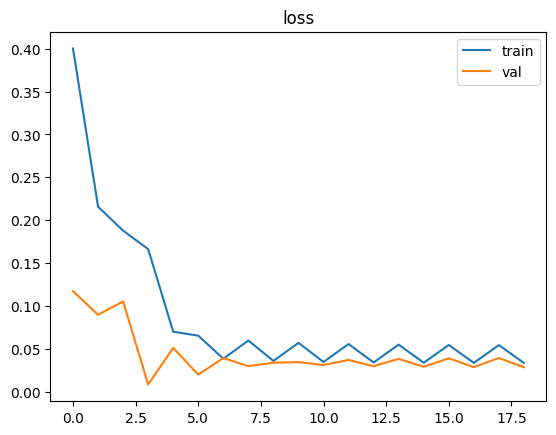

In [22]:
history = model.fit(train, n_epochs=1000, batch_size=200, val_batch_size=60)
plot_metrics(history)

In [23]:
train_result = model.evaluate(train)
result = model.evaluate(test)

for measure, value in train_result.items():
    print(f'train_{measure}: {value}')

for measure, value in result.items():
    print(f'{measure}: {value}')

train_loss: 0.03529518996365368
loss: 0.014022526890039444


In [24]:
x_test, y_test = next(iter(DataLoader(test, len(test))))
y_pred = model(x_test).detach().numpy()


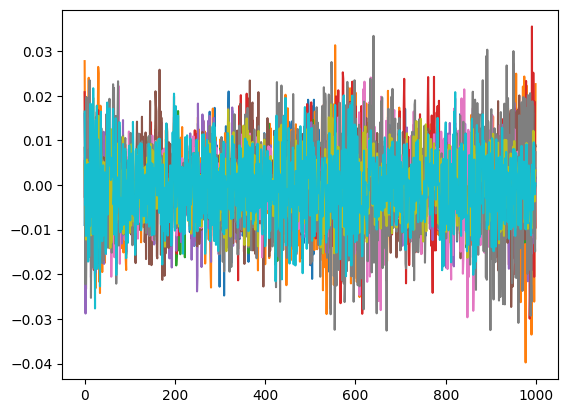

In [25]:
fig = plt.plot(y_pred[0].T)

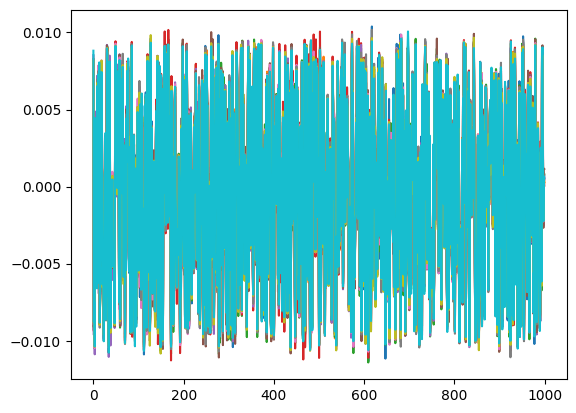

In [26]:
fig = plt.plot(y_pred.mean(0).T)

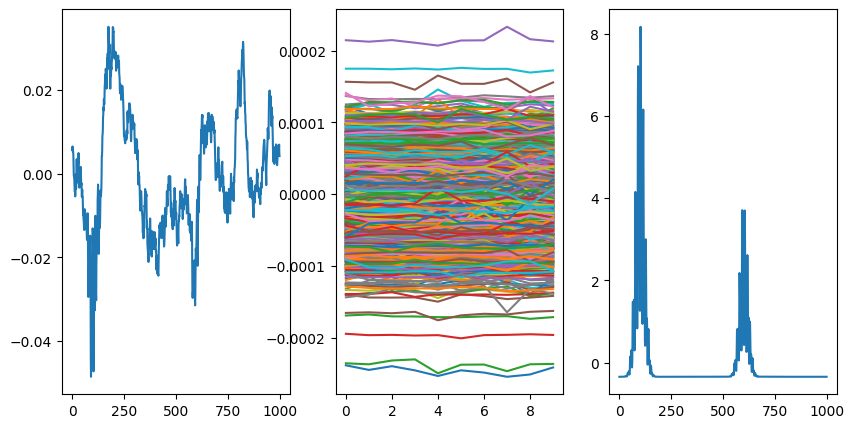

In [157]:
i = int(np.random.randint(len(y_pred)))

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(10, 5))

ax1.plot(x_test.mean((0,1)))
ax2.plot(y_pred.mean(0))
ax3.plot(y_test[i])

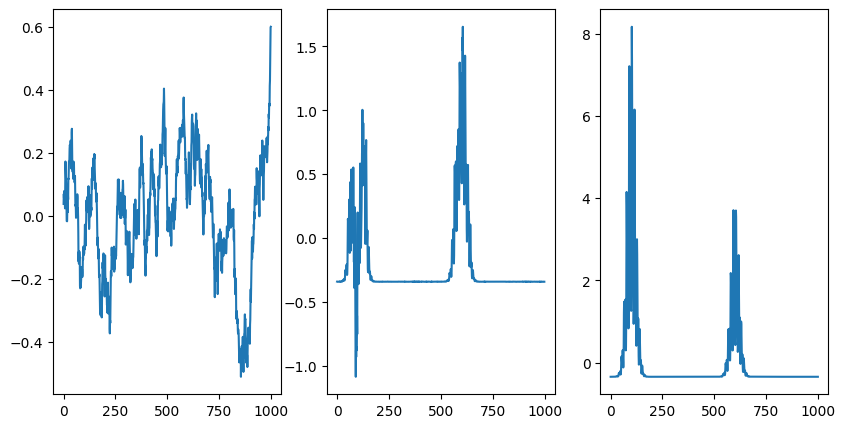

In [144]:
i = int(np.random.randint(len(y_pred)))

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(10, 5))

ax1.plot(x_test[i].mean((0)))
ax2.plot(y_pred[i])
ax3.plot(y_test[i])

In [117]:
w = model.unmixing_layer.i.detach().numpy()

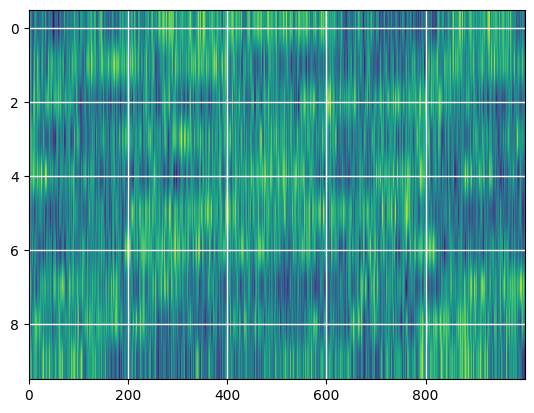

In [118]:
fig, ax = plt.subplots(1, 1)

ax.imshow(w.T, aspect='auto')
ax.grid(color='w', linewidth=1, which='both')

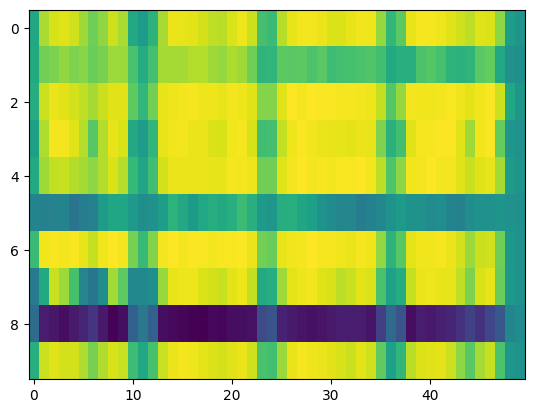

In [153]:
fig, ax = plt.subplots(1, 1)

ax.imshow(w.T[:, 75:125], aspect='auto')
# plt.pcolormesh(w.T, edgecolors='k', linewidth=2)

# ax.grid(color='w', linewidth=1, which='both')

In [126]:
for i, d in enumerate(distances):
    print(f'{i}: {d : .2f}')

0:  0.49
1:  0.03
2:  0.63
3:  0.40
4:  0.31
5:  0.00
6:  0.71
7:  0.50
8:  0.00
9:  0.44


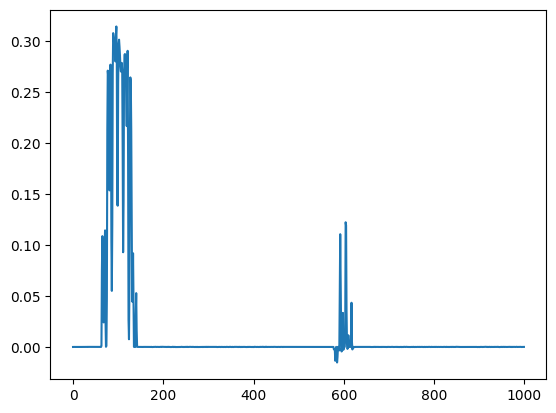

In [154]:
plt.plot(w.mean(1))